In [4]:
%pip install ultralytics scikit-learn seaborn --quiet
import os
import cv2
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from ultralytics import YOLO

# Verify dataset structure
dataset_path = "./C2A_Dataset/new_dataset3"
assert os.path.exists(f"{dataset_path}/train/images"), "Train images missing!"
assert os.path.exists(f"{dataset_path}/All labels with Pose information/labels"), "Pose labels missing!"
print("✅ Dataset verified!")

Note: you may need to restart the kernel to use updated packages.
✅ Dataset verified!


100%|██████████| 6129/6129 [00:34<00:00, 177.60it/s]


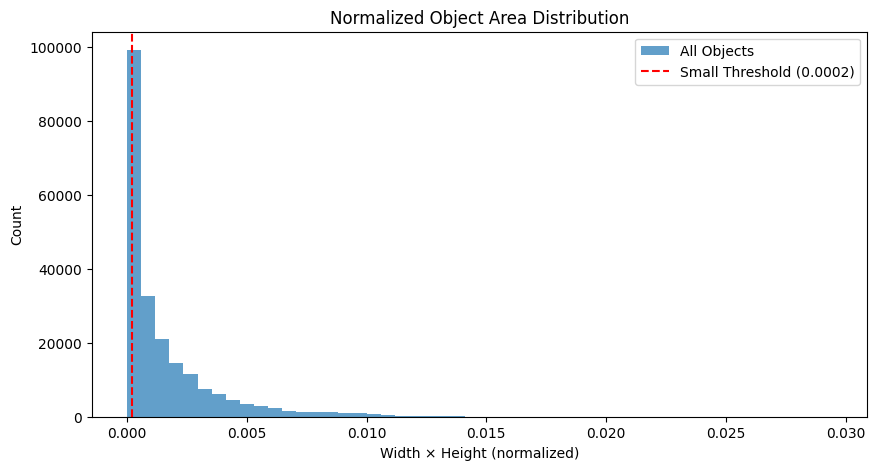

In [2]:
#Object Size Distribution
def get_object_sizes(label_dir):
    sizes = []
    for label_file in tqdm(os.listdir(label_dir)[:6129]):  # Sample for speed
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                _, _, _, w, h = map(float, line.strip().split())
                sizes.append(w * h)
    return sizes

sizes = get_object_sizes(f"{dataset_path}/train/labels")
small_threshold = np.percentile(sizes, 25)  # Dynamic threshold

plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=50, alpha=0.7, label='All Objects')
plt.axvline(small_threshold, color='r', linestyle='--', label=f'Small Threshold ({small_threshold:.4f})')
plt.title("Normalized Object Area Distribution")
plt.xlabel("Width × Height (normalized)")
plt.ylabel("Count")
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 180.97it/s]
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


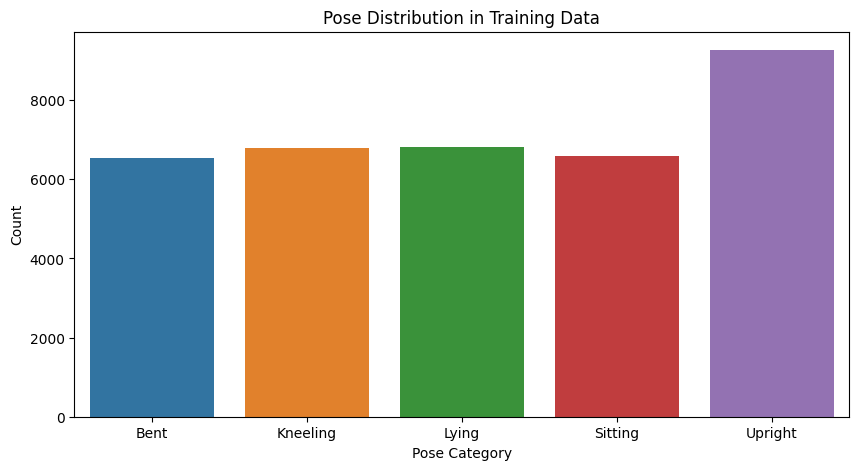

In [3]:
pose_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # 0:Bent, 1:Kneeling, 2:Lying, 3:Sitting, 4:Upright

# Iterate through label files
label_dir = f"{dataset_path}/All labels with Pose information/labels"
for pose_file in tqdm(os.listdir(label_dir)[:1000]):
    file_path = os.path.join(label_dir, pose_file)
    with open(file_path, 'r') as f:
        for line in f:  # Read ALL lines in the file
            parts = line.strip().split()
            if len(parts) > 5:  # Check if pose ID exists
                try:
                    pose_id = int(parts[5])
                    if pose_id in pose_counts:  # Ensure valid pose ID
                        pose_counts[pose_id] += 1
                except (ValueError, IndexError):
                    continue  # Skip invalid entries

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=list(pose_counts.keys()), y=list(pose_counts.values()))
plt.xticks([0, 1, 2, 3, 4], ['Bent', 'Kneeling', 'Lying', 'Sitting', 'Upright'])
plt.title("Pose Distribution in Training Data")
plt.xlabel("Pose Category")
plt.ylabel("Count")
plt.show()

In [4]:
#Base Config (All Data)
base_yaml = {
    "path": dataset_path,
    "train": f"{dataset_path}/train/images",
    "val": f"{dataset_path}/val/images",
    "names": {0: "human"},
    "nc": 1,
    "augment": True
}
with open("/kaggle/working/c2a.yaml", "w") as f:
    yaml.dump(base_yaml, f)

In [5]:
with open("/kaggle/working/c2a.yaml", "r") as f:
    print(f.read())

augment: true
names:
  0: human
nc: 1
path: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3
train: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images
val: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images



In [6]:
#Small-Object Config (Dynamic Threshold)
small_images = []
for label_file in tqdm(os.listdir(f"{dataset_path}/train/labels")[:6129]):
    with open(os.path.join(f"{dataset_path}/train/labels", label_file), 'r') as f:
        if any(float(line.split()[3]) * float(line.split()[4]) < small_threshold for line in f):
            small_images.append(f"{dataset_path}/train/images/{label_file.replace('.txt', '.png')}")

with open("/kaggle/working/train_small.txt", "w") as f:
    f.write("\n".join(small_images))

100%|██████████| 6129/6129 [00:03<00:00, 1899.64it/s]


In [7]:
small_yaml = {
    "path": dataset_path,
    "train": "/kaggle/working/train_small.txt",
    "val": f"{dataset_path}/val/images",
    "names": {0: "human"},
    "nc": 1,
    "augment": True,
    "mosaic": 1.0  # Enhanced augmentation
}
with open("/kaggle/working/c2a_small.yaml", "w") as f:
    yaml.dump(small_yaml, f)

In [8]:
with open("/kaggle/working/c2a_small.yaml", "r") as f:
    print(f.read())

augment: true
mosaic: 1.0
names:
  0: human
nc: 1
path: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3
train: /kaggle/working/train_small.txt
val: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images



In [9]:
from IPython.display import FileLink

# Stage 1: Train on all data
model = YOLO("yolov9e.pt")
results = model.train(
    data="/kaggle/working/c2a.yaml",
    epochs=25,
    imgsz=640,
    batch=8,
    device=0,
    project="/kaggle/working",  # Force save to working dir
    name="stage1_all_data",
    exist_ok=True
)

# Verify and display checkpoint
!ls /kaggle/working/stage1_all_data/weights  # Check files
stage1_ckpt = "/kaggle/working/stage1_all_data/weights/last.pt"
assert os.path.exists(stage1_ckpt), "Stage 1 failed - no checkpoint generated"
FileLink(stage1_ckpt)  # Click to download/view in Kaggle

# Stage 2: Train on small objects
model = YOLO(stage1_ckpt)
model.train(
    data="/kaggle/working/c2a_small.yaml",
    epochs=25,
    imgsz=640,
    batch=8,
    device=0,
    project="/kaggle/working",
    name="stage2_small_objects",
    exist_ok=True
)

print("✅ Training completed! Check files:")
!ls /kaggle/working/stage*  # Verify both stages

100%|██████████| 112M/112M [00:00<00:00, 197MB/s] 


Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/kaggle/working/c2a.yaml, epochs=25, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working, name=stage1_all_data, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/labels... 6129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6129/6129 [00:23<00:00, 258.73it/s]

train: WARNING ⚠️ /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images/flood_image0407_3.png: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/labels... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:11<00:00, 181.69it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val is not writeable, cache not saved.
Plotting labels to /kaggle/working/stage1_all_data/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/stage1_all_data
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      12.1G       1.25      0.879      1.028        109        640: 100%|██████████| 767/767 [13:50<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:15<00:00,  1.69it/s]


                   all       2043      72123      0.785      0.662      0.715      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.6G       1.25     0.8045      1.026         53        640: 100%|██████████| 767/767 [13:29<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.762      0.639      0.684       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      14.3G      1.226     0.7872      1.015         16        640: 100%|██████████| 767/767 [13:22<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.773      0.664      0.708      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      14.3G      1.185     0.7566      1.003         54        640: 100%|██████████| 767/767 [13:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.817      0.682      0.748      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      14.3G      1.136     0.7275       0.99         55        640: 100%|██████████| 767/767 [13:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.805      0.681      0.734      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      14.3G      1.117     0.7176     0.9876         75        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.806      0.687      0.746      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      14.3G      1.091      0.697     0.9814         49        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123       0.83      0.706      0.771      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      14.3G      1.071     0.6883     0.9802         34        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.826      0.718      0.777      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      14.3G      1.054     0.6737     0.9722         90        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.819      0.717      0.775      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      14.3G      1.037     0.6587     0.9665         28        640: 100%|██████████| 767/767 [13:21<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123       0.84      0.715      0.784      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      14.3G      1.021     0.6505      0.965         31        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.845      0.724      0.792       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      14.3G      1.006     0.6385     0.9586         46        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.849      0.721      0.791      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      14.3G     0.9986     0.6383     0.9586         17        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123      0.851      0.725      0.797      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      14.3G     0.9859     0.6247     0.9554         45        640: 100%|██████████| 767/767 [13:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123       0.85      0.729      0.796      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      14.3G     0.9735     0.6212     0.9541         45        640: 100%|██████████| 767/767 [13:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.845      0.735      0.801      0.554
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      14.3G     0.9411      0.611     0.9628         35        640: 100%|██████████| 767/767 [13:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.75it/s]


                   all       2043      72123      0.841      0.708      0.781      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      14.3G     0.9322     0.5997     0.9582         35        640: 100%|██████████| 767/767 [13:14<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.854      0.725      0.797      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      14.3G     0.9198     0.5945     0.9555         37        640: 100%|██████████| 767/767 [13:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.847      0.733      0.801      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      14.3G     0.9092     0.5856     0.9524         39        640: 100%|██████████| 767/767 [13:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123      0.847      0.734      0.804      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      14.3G     0.8945     0.5741     0.9472         44        640: 100%|██████████| 767/767 [13:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.73it/s]


                   all       2043      72123      0.854      0.734      0.806      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      14.3G     0.8846      0.567      0.945         26        640: 100%|██████████| 767/767 [13:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.858      0.735      0.807      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      14.3G      0.874     0.5586     0.9422         29        640: 100%|██████████| 767/767 [13:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.858      0.744      0.814      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      14.3G     0.8649     0.5525     0.9409         25        640: 100%|██████████| 767/767 [13:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.75it/s]


                   all       2043      72123      0.865       0.74      0.814      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      14.3G     0.8527     0.5395     0.9349         31        640: 100%|██████████| 767/767 [13:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.863      0.744      0.816      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      14.3G     0.8425     0.5355     0.9338         30        640: 100%|██████████| 767/767 [13:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.863      0.741      0.816      0.584

25 epochs completed in 6.102 hours.
Optimizer stripped from /kaggle/working/stage1_all_data/weights/last.pt, 117.2MB
Optimizer stripped from /kaggle/working/stage1_all_data/weights/best.pt, 117.2MB

Validating /kaggle/working/stage1_all_data/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 279 layers, 57,377,171 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:22<00:00,  1.55it/s]


                   all       2043      72123      0.863      0.741      0.816      0.584


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 30.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/stage1_all_data
best.pt  last.pt
New https://pypi.org/project/ultralytics/8.3.104 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/stage1_all_data/weights/last.pt, data=/kaggle/working/c2a_small.yaml, epochs=25, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working, name=stage2_small_objects, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, io

train: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/labels... 5205 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5205/5205 [00:10<00:00, 518.58it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/labels... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:05<00:00, 382.64it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val is not writeable, cache not saved.
Plotting labels to /kaggle/working/stage2_small_objects/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/stage2_small_objects
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      13.1G     0.9548     0.5827     0.9104        171        640: 100%|██████████| 651/651 [11:41<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.824      0.706      0.772      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      13.2G      1.017     0.6258     0.9276        368        640: 100%|██████████| 651/651 [11:23<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.845      0.727       0.79       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      13.2G      1.031      0.641     0.9309        264        640: 100%|██████████| 651/651 [11:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.831      0.724      0.785      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      13.2G      1.036     0.6398     0.9296        361        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.837      0.717      0.784      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      13.2G      1.023     0.6351      0.931        304        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.852      0.726      0.792      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      13.2G      1.012     0.6276     0.9275        111        640: 100%|██████████| 651/651 [11:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.853      0.719      0.789      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      13.2G      1.011     0.6228     0.9241        153        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.73it/s]


                   all       2043      72123      0.828      0.718      0.782      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      13.2G      1.009     0.6173      0.923        243        640: 100%|██████████| 651/651 [11:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.846      0.723      0.792       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      13.2G     0.9971     0.6131      0.921        132        640: 100%|██████████| 651/651 [11:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.838      0.733      0.795      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      13.2G     0.9967     0.6129     0.9229        251        640: 100%|██████████| 651/651 [11:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.839      0.723      0.793      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      13.2G     0.9807     0.5986     0.9169        284        640: 100%|██████████| 651/651 [11:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.72it/s]


                   all       2043      72123      0.843      0.731      0.798       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      13.2G     0.9877     0.6042     0.9221        234        640: 100%|██████████| 651/651 [11:19<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123       0.84      0.727      0.792       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      13.2G     0.9709     0.5918     0.9179        234        640: 100%|██████████| 651/651 [11:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.74it/s]


                   all       2043      72123      0.841      0.737      0.804      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      13.2G     0.9597     0.5853     0.9122        184        640: 100%|██████████| 651/651 [11:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123      0.863      0.739       0.81      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      13.2G     0.9477     0.5773     0.9122        135        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.75it/s]


                   all       2043      72123       0.85       0.73      0.803      0.556
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      13.2G     0.9149     0.5658       0.92        194        640: 100%|██████████| 651/651 [11:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.75it/s]


                   all       2043      72123      0.862      0.738      0.809      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      13.2G     0.9095     0.5617     0.9201        137        640: 100%|██████████| 651/651 [11:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:12<00:00,  1.76it/s]


                   all       2043      72123      0.856      0.747      0.813      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      13.2G     0.8952     0.5531     0.9155        117        640: 100%|██████████| 651/651 [11:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.71it/s]


                   all       2043      72123      0.857      0.744      0.812      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      13.2G     0.8855     0.5462     0.9138        171        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123       0.86      0.744      0.814      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      13.2G     0.8826     0.5415     0.9108        148        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.73it/s]


                   all       2043      72123      0.864      0.746      0.817      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      13.2G     0.8709     0.5338     0.9089        122        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123      0.864      0.738      0.816      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      13.2G     0.8652      0.531     0.9073        175        640: 100%|██████████| 651/651 [11:17<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:14<00:00,  1.73it/s]


                   all       2043      72123      0.863      0.742      0.817      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      13.2G     0.8547     0.5208     0.9044        135        640: 100%|██████████| 651/651 [11:16<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.75it/s]


                   all       2043      72123       0.87      0.749      0.822      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      13.2G     0.8434     0.5101     0.9028        155        640: 100%|██████████| 651/651 [11:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:13<00:00,  1.75it/s]


                   all       2043      72123      0.868      0.745      0.821      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      13.2G     0.8425     0.5082     0.9003        143        640: 100%|██████████| 651/651 [11:14<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:12<00:00,  1.76it/s]


                   all       2043      72123      0.874      0.745      0.822      0.596

25 epochs completed in 5.250 hours.
Optimizer stripped from /kaggle/working/stage2_small_objects/weights/last.pt, 117.2MB
Optimizer stripped from /kaggle/working/stage2_small_objects/weights/best.pt, 117.2MB

Validating /kaggle/working/stage2_small_objects/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 279 layers, 57,377,171 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:22<00:00,  1.55it/s]


                   all       2043      72123      0.873      0.745      0.822      0.596


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 30.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/stage2_small_objects
✅ Training completed! Check files:
/kaggle/working/stage1_all_data:
args.yaml					  train_batch11505.jpg
confusion_matrix_normalized.png			  train_batch11506.jpg
confusion_matrix.png				  train_batch11507.jpg
events.out.tfevents.1744053552.f9473b88ae7f.18.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg

/kaggle/working/stage2_small_objects:
args.yaml					  train_batch1.jpg
confusion_matrix_normalized.png			  train_batch2.jpg
confusion_matrix.png				  train_batch9765.jpg
events.out.tfevents.1744075680.f9473b88ae7f.18.1  train_batch9766.jpg
F1_curve.png					  trai

In [10]:
# Compress and download
!zip -r models.zip /kaggle/working/stage*
FileLink("models.zip")

  adding: kaggle/working/stage1_all_data/ (stored 0%)
  adding: kaggle/working/stage1_all_data/train_batch2.jpg (deflated 3%)
  adding: kaggle/working/stage1_all_data/results.csv (deflated 60%)
  adding: kaggle/working/stage1_all_data/val_batch1_pred.jpg (deflated 3%)
  adding: kaggle/working/stage1_all_data/train_batch1.jpg (deflated 4%)
  adding: kaggle/working/stage1_all_data/val_batch1_labels.jpg (deflated 3%)
  adding: kaggle/working/stage1_all_data/P_curve.png (deflated 18%)
  adding: kaggle/working/stage1_all_data/val_batch2_labels.jpg (deflated 3%)
  adding: kaggle/working/stage1_all_data/F1_curve.png (deflated 17%)
  adding: kaggle/working/stage1_all_data/labels.jpg (deflated 33%)
  adding: kaggle/working/stage1_all_data/train_batch11507.jpg (deflated 6%)
  adding: kaggle/working/stage1_all_data/events.out.tfevents.1744053552.f9473b88ae7f.18.0 (deflated 94%)
  adding: kaggle/working/stage1_all_data/args.yaml (deflated 53%)
  adding: kaggle/working/stage1_all_data/train_batch11

/kaggle/working/models.zip

In [11]:
!cat /kaggle/working/c2a.yaml

augment: true
names:
  0: human
nc: 1
path: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3
train: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/train/images
val: /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/val/images


In [12]:
!ls /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images | head -5

collapsed_building_image0001_3.png
collapsed_building_image0002_1.png
collapsed_building_image0002_3.png
collapsed_building_image0004_1.png
collapsed_building_image0005_2.png
ls: write error: Broken pipe


In [13]:
# 2. Correct validation approach (3 options - try each until one works)

### OPTION 1: Direct path specification
try:
    results = model.val(
        data={
            "val": "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images",  # Absolute path
            "names": {0: "human"}
        },
        plots=True,
        save_json=True
    )
    print("✅ Validation successful with direct path!")
except Exception as e:
    print(f"Option 1 failed: {str(e)}")

### OPTION 2: Modified YAML approach
# Update your c2a.yaml to explicitly include test path
with open("/kaggle/working/c2a_fixed.yaml", "w") as f:
    yaml.dump({
        "path": "/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3",
        "train": "train/images",
        "val": "val/images",
        "test": "test/images",  # Explicit test path
        "names": {0: "human"},
        "nc": 1
    }, f)

try:
    results = model.val(
        data="/kaggle/working/c2a_fixed.yaml",
        split="test",  # Just 'test' not 'test/images'
        plots=True,
        save_json=True
    )
    print("✅ Validation successful with fixed YAML!")
except Exception as e:
    print(f"Option 2 failed: {str(e)}")

### OPTION 3: Manual validation
if not 'results' in locals():  # If above options failed
    print("Running manual validation...")
    test_images = [f for f in os.listdir("/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images") if f.endswith(('.png'))]
    metrics = {"tp":0, "fp":0, "fn":0}
    
    for img_file in tqdm(test_images[:50]):  # Validate on 50 images
        img_path = f"/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/{img_file}"
        label_path = f"/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/labels/{img_file.replace('.png','.txt')}"
        
        # Run prediction
        pred = model.predict(img_path, conf=0.5)[0]
        
        # Compare with ground truth (simplified)
        with open(label_path) as f:
            gt_boxes = len(f.readlines())
        metrics["tp"] += min(len(pred.boxes), gt_boxes)
        metrics["fp"] += max(0, len(pred.boxes)-gt_boxes)
        metrics["fn"] += max(0, gt_boxes-len(pred.boxes))
    
    # Calculate metrics
    precision = metrics["tp"]/(metrics["tp"]+metrics["fp"]+1e-10)
    recall = metrics["tp"]/(metrics["tp"]+metrics["fn"]+1e-10)
    print(f"\n📊 Manual Validation Metrics (50 images):")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")
    print(f"TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 279 layers, 57,377,171 parameters, 0 gradients, 189.1 GFLOPs
Option 1 failed: Dataset '{'val': '/kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images', 'names': {0: 'human'}}' for task=detect not found ❌
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/labels... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:13<00:00, 156.61it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 256/256 [01:33<00:00,  2.73it/s]


                   all       2043      72523      0.873      0.752      0.826      0.612


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 34.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving /kaggle/working/stage2_small_objects/predictions.json...
Results saved to /kaggle/working/stage2_small_objects
✅ Validation successful with fixed YAML!



image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/flood_image0309_1.png: 544x640 13 humans, 74.7ms
Speed: 3.9ms preprocess, 74.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


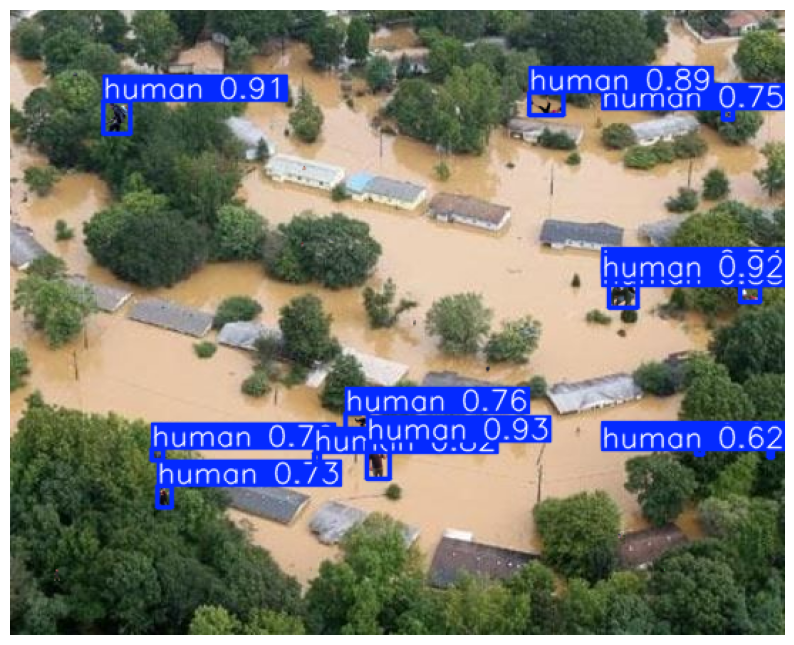


image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/collapsed_building_image0473_2.png: 608x640 42 humans, 78.6ms
Speed: 4.6ms preprocess, 78.6ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


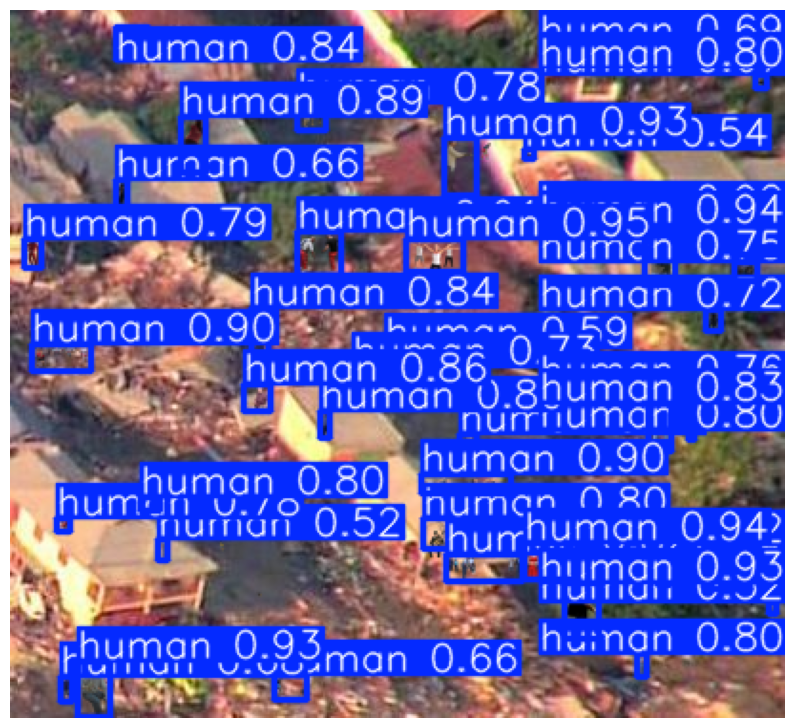


image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/traffic_incident_image0105_3.png: 640x640 32 humans, 49.2ms
Speed: 3.3ms preprocess, 49.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


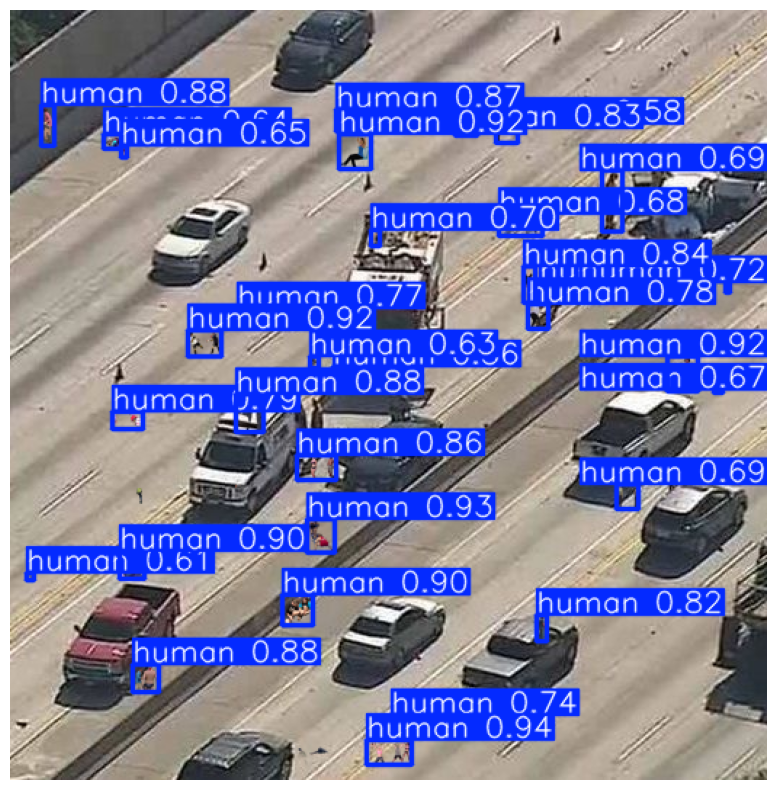


image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/collapsed_building_image0195_1.png: 640x640 24 humans, 48.6ms
Speed: 3.7ms preprocess, 48.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/collapsed_building_image0027_0.png: 640x640 21 humans, 48.3ms
Speed: 2.1ms preprocess, 48.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/traffic_incident_image0421_1.png: 384x640 20 humans, 79.3ms
Speed: 1.7ms preprocess, 79.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/fire_image0285_1.png: 640x640 25 humans, 45.4ms
Speed: 2.3ms preprocess, 45.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/c2a-dataset/C2A_Dataset/new_dataset3/test/images/collapsed_

In [14]:
import random
# 1. Prediction Samples
def plot_predictions(model, image_dir, n=3):
    for img_file in random.sample(os.listdir(image_dir), n):
        img_path = os.path.join(image_dir, img_file)
        results = model.predict(img_path, conf=0.5)
        for r in results:
            plt.figure(figsize=(10,10))
            plt.imshow(r.plot()[:, :, ::-1])  # BGR to RGB
            plt.axis('off')
            plt.show()

plot_predictions(model, f"{dataset_path}/test/images")

# 2. Save Error Cases
error_dir = "/kaggle/working/error_analysis"
os.makedirs(error_dir, exist_ok=True)
test_images = os.listdir(f"{dataset_path}/test/images")[:20]  # Sample 20
for img in test_images:
    label = img.replace(".png", ".txt")
    gt_boxes = len(open(f"{dataset_path}/test/labels/{label}").readlines())
    pred = model.predict(f"{dataset_path}/test/images/{img}", conf=0.5)
    if len(pred[0].boxes) != gt_boxes:
        pred[0].save(filename=f"{error_dir}/{img}")

print(f"\n🔍 Error cases saved to {error_dir}/")